In [1]:
# -*- coding: utf-8 -*-
"""
Example script to forward/back-project some data.

In this example, we will create projection data and images purely
from within Python.
    
Note that the code that use geometric shapes below needs a version of STIR
later than 3Nov2018. There are no other prerequisites (i.e. no script to run first!).

Author: Kris Thielemans
"""

'\nExample script to forward/back-project some data.\n\nIn this example, we will create projection data and images purely\nfrom within Python.\n    \nNote that the code that use geometric shapes below needs a version of STIR\nlater than 3Nov2018. There are no other prerequisites (i.e. no script to run first!).\n\nAuthor: Kris Thielemans\n'

In [2]:
%matplotlib notebook

# Initial imports

In [3]:
import stir
import stirextra
#import numpy
import matplotlib.pyplot as plt

# We first need to define a scanner

In [4]:
# STIR has multiple scanners predefined.
print(stir.Scanner.list_all_names())

ECAT 931
ECAT 951
ECAT 953
ECAT 921 , ECAT EXACT , EXACT
ECAT 925 , ECAT ART
ECAT 961 , ECAT HR
ECAT 962 , ECAT HR+
ECAT EXACT 3D , EXACT 3D , ECAT HR++ , ECAT 966
ECAT 1080 , Biograph 16 , 1080
Siemens mMR , mMR , 2008
Siemens mCT , mCT , 2011 , 1104
PRT-1 , RPT
HiDAC
GE Advance , Advance
GE Discovery LS , Discovery LS
GE Discovery ST , Discovery ST
GE Discovery STE , Discovery STE
GE Discovery RX , Discovery RX
GE Discovery 600 , Discovery 600
GE Discovery 690 , Discovery 690 , GE Discovery 710 , Discovery 710
Positron HZL/R
RATPET
PANDA
HYPERimage
nanoPET
HRRT
Allegro , Philips Allegro
GeminiTF , Philips GeminiTF
Userdefined



# Let's use an old scanner that doesn't have too many detectors (for speed)

In [5]:
scanner=stir.Scanner.get_scanner_from_name("ECAT 931")
print(scanner.parameter_info())

Scanner parameters:= 
Scanner type := ECAT 931
Number of rings                          := 8
Number of detectors per ring             := 512
Inner ring diameter (cm)                 := 102
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 1.35
Default bin size (cm)                    := 0.3129
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 192
Default number of arc-corrected bins     := 192
Energy resolution := 0.37
Reference energy (in keV) := 511
Number of blocks per bucket in transaxial direction         := 4
Number of blocks per bucket in axial direction              := 2
Number of crystals per block in axial direction             := 4
Number of crystals per block in transaxial direction        := 8
Number of detector layers                                   := 1
Number of crystals per singles unit in axial direction      := 4
Number of crystals per singles unit in transaxial direction := 32
end sc

# Now we need to describe the actual size of the projection data

In [6]:
# We call this the `projection data information`.
#
# We will use a "2D" PET acquisition in this example.
# This corresponds to `span=3`, with only 1 "segment".
# You can ignore this terminology now, or check it out at
# http://stir.sourceforge.net/documentation/STIR-glossary.pdf
span=3;
max_ring_diff=1;
# use default number of "views" (or "azimutal angles")
num_views=int(scanner.get_num_detectors_per_ring()/2);
# construct the object using ProjDataInfoCTI
# (the naming of this function was related to the scanner manufacturer, but will be changed in the future)
proj_data_info=stir.ProjDataInfo.ProjDataInfoCTI(scanner,
                                                 span, max_ring_diff,
                                                 num_views, scanner.get_default_num_arccorrected_bins());


# Create an empty image with suitable dimensions and voxel sizes

In [7]:
# This image will cover the whole FOV and having the "traditional"
# z-spacing of half the scanner ring-distance. (STIR needs this at the moment).
# For illustration, we use smaller voxels than the default (we "zoom in")
zoom=1.2;
image_data=stir.FloatVoxelsOnCartesianGrid(proj_data_info, zoom);

# initialise a projection matrix

In [8]:
# Using ray-tracing here
# Note that the default is to restrict the projection to a cylindrical FOV
projmatrix=stir.ProjMatrixByBinUsingRayTracing();
projmatrix.set_up(proj_data_info, image_data);

# construct projectors

In [9]:
forwardprojector=stir.ForwardProjectorByBinUsingProjMatrixByBin(projmatrix);
forwardprojector.set_up(proj_data_info, image_data);

backprojector=stir.BackProjectorByBinUsingProjMatrixByBin(projmatrix);
backprojector.set_up(proj_data_info, image_data)

# create projection data for output of forward projection

In [10]:
# We'll create the data in memory here
exam_info=stir.ExamInfo();
projdataout=stir.ProjDataInMemory(exam_info, proj_data_info);
# Note: we could write to file, but it is right now a bit complicated to open a
#  projection data file for read/write:
#  inout=stir.ios.trunc|stir.ios.ios_base_in|stir.ios.out;
#  projdataout=stir.ProjDataInterfile(exam_info, proj_data_info, 'my_test_python_projection.hs',inout);

# Done creating data and projectors!

In [11]:
# Let's now create an interesting image with 2 cylinders

# create a first cylinder (note: units are in mm)

In [12]:
# we'll put it in the middle of the scanner
# This is currently a bit difficult in STIR due to its
# choice of origin (the middle of the first ring).
length=60
radius=40
middle_slice=int((image_data.get_max_z()+image_data.get_min_z())/2)
z_centre=middle_slice*image_data.get_voxel_size().z()
# create a coordinate for the centre (note the z,y,x order)
centre=stir.FloatCartesianCoordinate3D(z_centre,0,0)
# create a geometrical shape
shape=stir.EllipsoidalCylinder(length, radius, radius,
                               centre)

# we set the image to a discretised version of this shape

In [13]:
# (the last argument means we'll sample every voxel only once)
shape.construct_volume(image_data, stir.IntCartesianCoordinate3D(1,1,1))

# Let's add another translated cylinder

In [14]:
# The way to do this is currently still awkward. Apologies.
shape.translate(stir.FloatCartesianCoordinate3D(15,90,40))
# make a clone and fill that one with the second shape
image_data2=image_data.clone()
shape.construct_volume(image_data2, stir.IntCartesianCoordinate3D(1,1,1))
# now add that to the previous one (currently messy as we need to pass through numpy, sorry)
image_data_array=stirextra.to_numpy(image_data);
image_data_array+=stirextra.to_numpy(image_data2);
image_data.fill(image_data_array.flat)

# display 2 transaxial slices of the volume

<IPython.core.display.Javascript object>


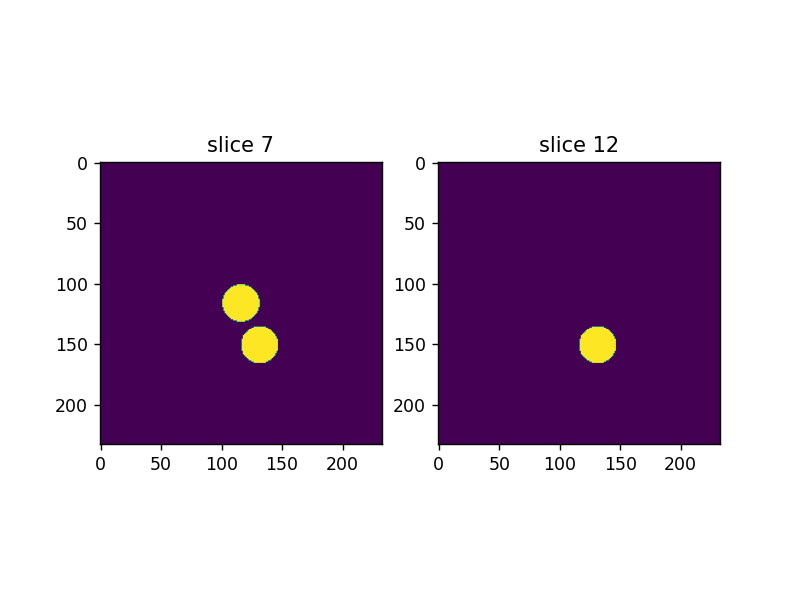

In [15]:
maxforplot=image_data.find_max(); # save for display
image_data_array=stirextra.to_numpy(image_data);
plt.figure();
plt.subplot(1,2,1)
plt.imshow(image_data_array[middle_slice,:,:]);
plt.clim(0,maxforplot)
plt.title('slice %d' % middle_slice)
plt.subplot(1,2,2)
plt.imshow(image_data_array[middle_slice+5,:,:]);
plt.title('slice %d' % (middle_slice+5))
plt.clim(0,maxforplot)
plt.show()

# forward project the image!

In [16]:
forwardprojector.forward_project(projdataout, image_data);

# get the output

In [17]:
# With the above settings, we are simulating an acquisition in "2D" mode for a
# scanner with "rings" of detector crystals. There will therefore be only a
# single "segment", corresponding to LORs which are (almost) orthogonal to the
# scanner axis.
seg=projdataout.get_segment_by_sinogram(0);

# A note on projection data sizes

In [18]:
# Segment 0 is a 3D array of size
#    num_sinograms x num_views x num_tangential_positions.
# with the order of the indices as above if we ask for the data "by sinogram"
# As we used "span">1, there will be both "direct" and "indirect" sinograms.
# (Don't worry if you don't know the relevant terminology.)
# We will therefore have the same number of sinograms as slices
# in the image (both equal to 2*num_rings-1).
print(seg.shape())
print(image_data.shape())
print(scanner.get_num_rings())

(15, 256, 192)
(15, 233, 233)
8


# Display the data

<IPython.core.display.Javascript object>


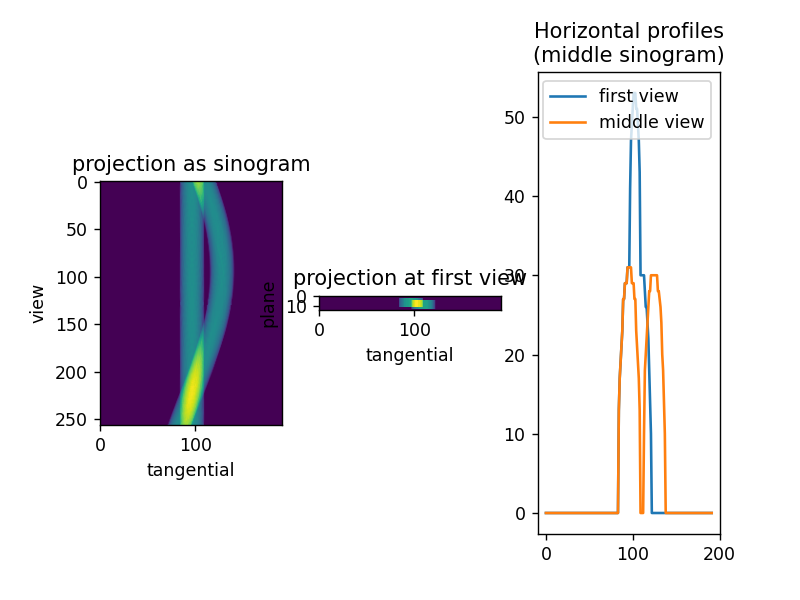

In [19]:
# We'll display a single sinogram and a horizontal profile (i.e. projections
# for a single "slice" and "view"), but you could display the data in another cut of course.
seg_array=stirextra.to_numpy(seg);
plt.figure();
plt.subplot(1,3,1)
plt.imshow(seg_array[middle_slice,:,:]);
plt.title('projection as sinogram')
plt.xlabel('tangential')
plt.ylabel('view')
plt.subplot(1,3,2)
plt.imshow(seg_array[:,0,:]);
plt.title('projection at first view')
plt.xlabel('tangential')
plt.ylabel('plane')
plt.subplot(1,3,3)
plt.plot(seg_array[middle_slice,0,:])
plt.plot(seg_array[middle_slice,int(proj_data_info.get_num_views()/2),:])
plt.title('Horizontal profiles\n(middle sinogram)');
plt.legend(('first view', 'middle view'));


# display all sinograms in a (repeated) loop

<IPython.core.display.Javascript object>


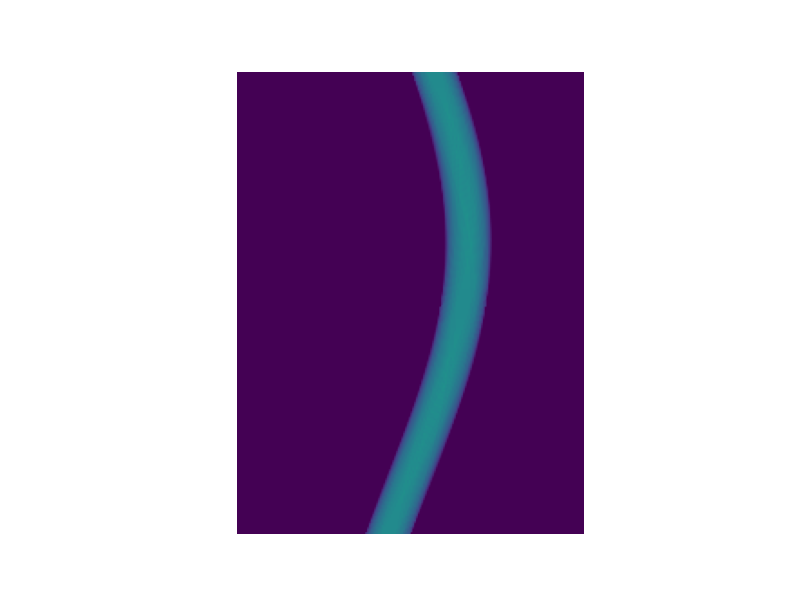

In [20]:
#%% It might make more sense to you if you display every view in the animation
# (as in the evaluate_simulation* scripts), so you could try this as well.
import matplotlib.animation as animation
bitmaps=[]
fig=plt.figure()
for sino in range(seg_array.shape[0]):
    bitmap=plt.imshow(seg_array[sino,:,:]);
    plt.clim(0,seg_array.max())
    plt.axis('off');
    bitmaps.append([bitmap])
ani = animation.ArtistAnimation(fig, bitmaps, interval=100, blit=True, repeat_delay=1000)


# backproject this projection data

In [20]:
# we will do this into a new image of the same geometry as the original
back_projection=image_data.get_empty_copy()
backprojector.back_project(back_projection, projdataout);

# display the same slices as above

<IPython.core.display.Javascript object>


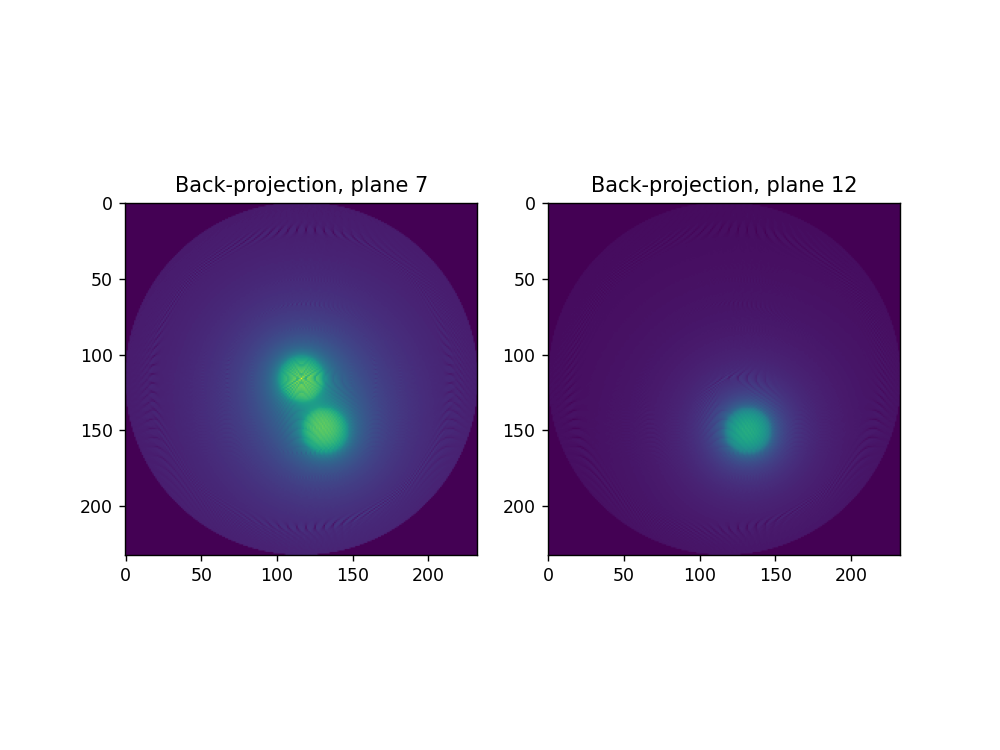

In [21]:
maxforplot=back_projection.find_max(); # save for display
back_projection_array=stirextra.to_numpy(back_projection);
plt.figure();
plt.subplot(1,2,1)
plt.imshow(back_projection_array[middle_slice,:,:]);
plt.clim(0,maxforplot)
plt.title('Back-projection, plane %d' % middle_slice)
plt.subplot(1,2,2)
plt.imshow(back_projection_array[middle_slice+5,:,:]);
plt.title('Back-projection, plane %d' % (middle_slice+5))
plt.clim(0,maxforplot);

# Preliminary conclusion

In [ ]:
# This should show that simple backprojection gives a smooth version of the
# original image back. It's therefore useful as a sanity check.
# Actual image reconstruction needs to work a bit harder...

# Let's do a few minimal experiments on changing the projector. For this experiment, we will use a larger cylinder in the centre

In [22]:
length=60
radius=200
middle_slice=int((image_data.get_max_z()+image_data.get_min_z())/2)
z_centre=middle_slice*image_data.get_voxel_size().z()
centre=stir.FloatCartesianCoordinate3D(z_centre,0,0)
shape=stir.EllipsoidalCylinder(length, radius, radius,
                               centre)
shape.construct_volume(image_data, stir.IntCartesianCoordinate3D(1,1,1))

# forward project it and display

<IPython.core.display.Javascript object>


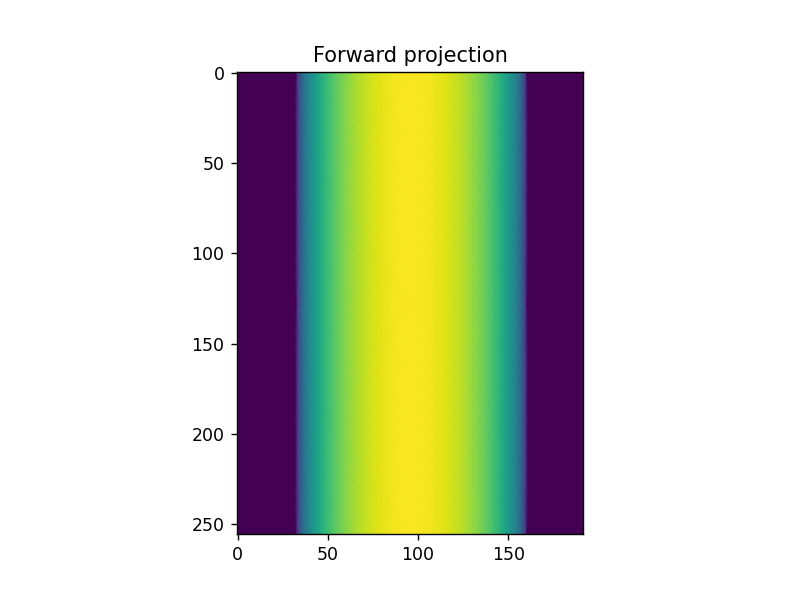

In [23]:
forwardprojector.forward_project(projdataout, image_data);
seg=projdataout.get_segment_by_sinogram(0);
seg_array=stirextra.to_numpy(seg);
plt.figure();
plt.imshow(seg_array[middle_slice,:,:]);
plt.title('Forward projection');

# back-projection and display

<IPython.core.display.Javascript object>


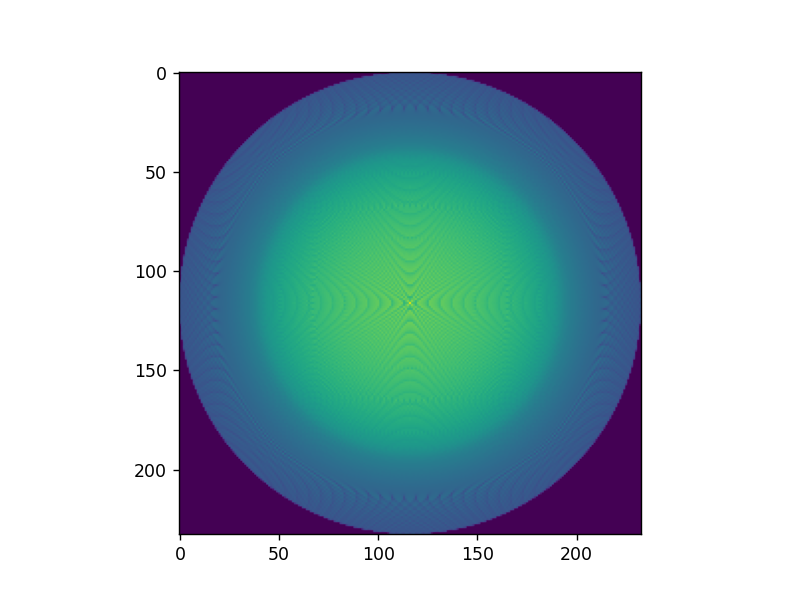

In [24]:
# This shows a beautiful pattern, a well-known feature of a ray-tracing matrix
back_projection.fill(0) # set to zero, otherwise it will add to the previous results
backprojector.back_project(back_projection, projdataout);
back_projection_array=stirextra.to_numpy(back_projection);
plt.figure();
plt.imshow(back_projection_array[middle_slice,:,:]);

# Let's use more LORs per sinogram bin (which will be a bit slower of course)

In [25]:
projmatrix.set_num_tangential_LORs(10);
# Need to call set_up again
projmatrix.set_up(proj_data_info, image_data);

# You could re-run the forward projection, but we'll skip that for now

In [ ]:
# The output will be almost identical anyway.
# forwardprojector.forward_project(projdataout, image_data);

# Run another backprojection and display

<IPython.core.display.Javascript object>


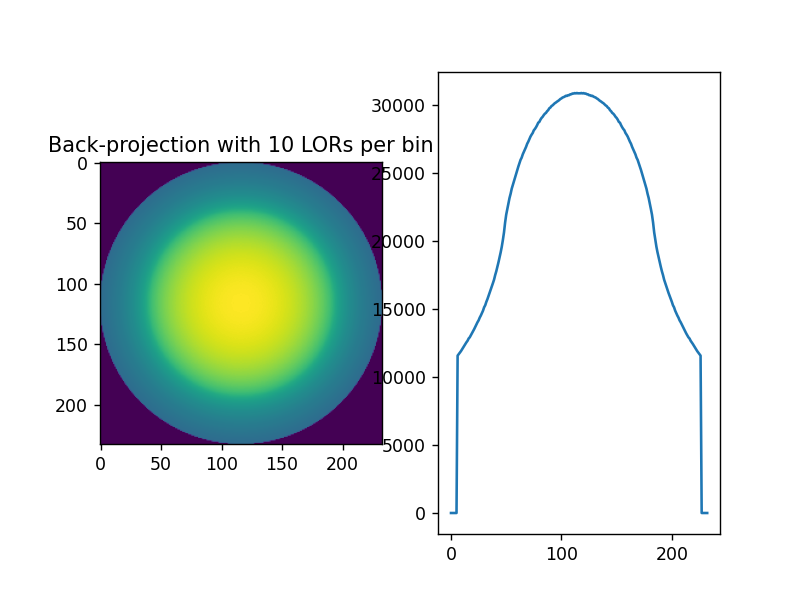

In [26]:
back_projection_10=back_projection.get_empty_copy()
backprojector.back_project(back_projection_10, projdataout);
back_projection_10_array=stirextra.to_numpy(back_projection_10);
plt.figure();
plt.subplot(1,2,1)
plt.imshow(back_projection_10_array[middle_slice,:,:]);
plt.title('Back-projection with 10 LORs per bin')
plt.subplot(1,2,2)
plt.plot(back_projection_10_array[middle_slice,80,:]);

# compare profiles to check if overall features are fine

<IPython.core.display.Javascript object>


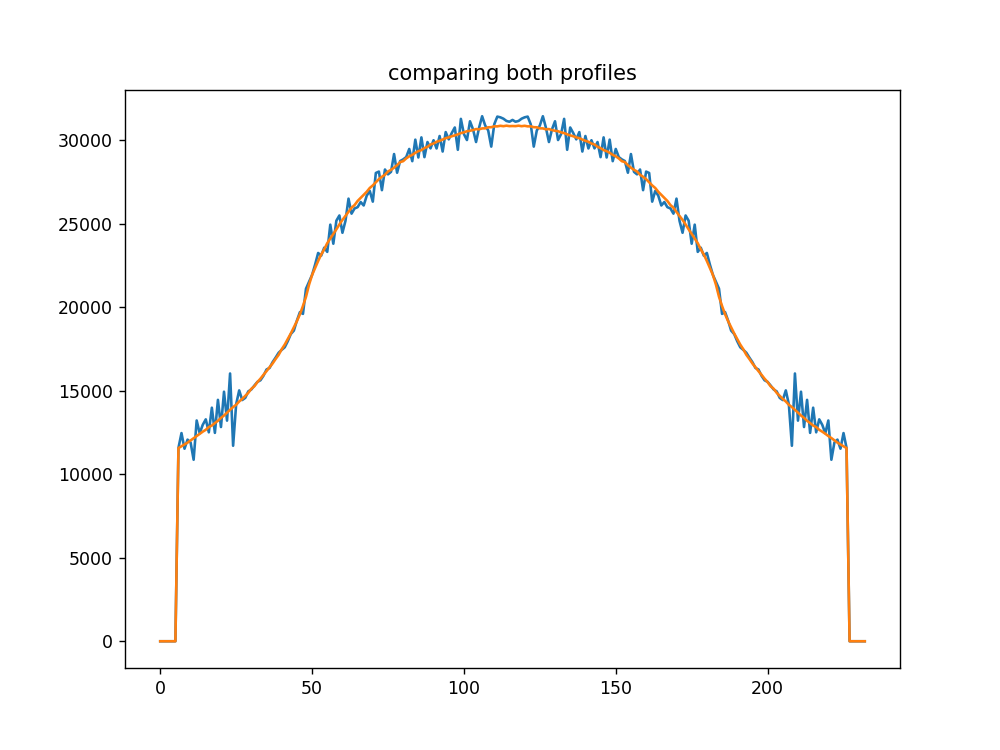

In [27]:
plt.figure()
plt.plot(back_projection_array[middle_slice,80,:])
plt.plot(back_projection_10_array[middle_slice,80,:])
plt.title('comparing both profiles');

# What now?

In [ ]:
# You have all the basic tools to do a simple analytic PET simulation
# (no attenuation etc here yet though).
# You can also add other shapes (stir.Ellipsoid etc), or just make them yourself
# using numpy commands